In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf

import seaborn as sns

# Data Pre-Processing

In [2]:
#load up grad_data
grad_data = pd.read_csv('../data/Merged Data/GRADUATION_WITH_CENSUS.csv')


In [3]:
#import preprocessed data
#df4 = pd.read_csv('../sfdat28_work/election_by_school_dist.csv')

In [3]:
grad_data.shape

(9907, 580)

In [4]:
grad_data.isnull().sum().sort_values(ascending=False)

Flag                                9883
MAM_COHORT_1112                     6114
MAM_RATE_1112                       6114
MTR_RATE_1112                       5750
MTR_COHORT_1112                     5750
LEP_COHORT_1112                     5304
MAS_COHORT_1112                     4771
MAS_RATE_1112                       4771
MBL_COHORT_1112                     3623
MBL_RATE_1112                       3623
MHI_RATE_1112                       2674
MHI_COHORT_1112                     2674
CWD_RATE_1112                        347
CWD_COHORT_1112                      347
Mail_Return_Rate_CEN_2010            237
pct_Mailback_Count_CEN_2010          230
pct_RPLCMNT_FRMS_CEN_2010            230
pct_FRST_FRMS_CEN_2010               230
pct_TEA_Update_Leave_CEN_2010        230
pct_TEA_MailOutMailBack_CEN_2010     230
pct_Census_UAA_CEN_2010              230
pct_Deletes_CEN_2010                 230
pct_Vacant_CEN_2010                  230
pct_Census_Mail_Returns_CEN_2010     230
pct_BILQ_Mailout

In [5]:
#load election_data
election_data = pd.read_csv('../data/us-election-2016-results-by-county.csv')

In [6]:
election_data.shape

(15565, 8)

In [7]:
election_data.isnull().sum()

StateCode             0
StateName             0
CountyFips            0
CountyName            0
CountyTotalVote       0
Party                 0
Candidate             0
VoteCount          2338
dtype: int64

In [8]:
#selecting features out of the 580 original, probably can do some ML feauture selection here
grad_df = grad_data[['STNAM','FIPST','County','Percentage',
           'School.District','ALL_COHORT_1112',
           'ALL_RATE_1112', 'PUB_ASST_INC_ACS_08_12',
           'MAS_COHORT_1112','MAS_RATE_1112','MBL_COHORT_1112',
           'MBL_RATE_1112','MHI_COHORT_1112','MHI_RATE_1112',
           'MWH_COHORT_1112','pct_URBANIZED_AREA_POP_CEN_2010','pct_College_ACS_08_12',
           'pct_RURAL_POP_CEN_2010','pct_URBAN_CLUSTER_POP_CEN_2010',
           'MWH_RATE_1112','pct_US_Cit_Nat_ACS_08_12','Mobile_Homes_ACS_08_12',
           'Tot_Population_CEN_2010','Males_CEN_2010','Females_CEN_2010',
           'Hispanic_CEN_2010','NH_White_alone_CEN_2010','NH_Blk_alone_CEN_2010',
           'NH_AIAN_alone_CEN_2010','NH_Asian_alone_CEN_2010','leaid11']]


In [9]:
#function for feature engineering a CountyFips column in grad_df
def fipsify(leaid11):
    record = grad_data[grad_data['leaid11'] == leaid11][['FIPST','County']].reset_index()
    #print grad_data[grad_data['leaid11'] == leaid11][['leaid11','FIPST','County']]
    #print (len(int(record.County[0])))
           
    if len(str(record.County.iloc[0])) == 3:
        return int((str(record.FIPST.iloc[0]) + str(int(record.County.iloc[0]))))
    
    elif len(str(record.County.iloc[0])) == 2:
        return int(str(record.FIPST.iloc[0]) + '0' + str(record.County.iloc[0]))
    
    else:
        return int(str(record.FIPST.iloc[0]) + '00' + str(record.County.iloc[0]))

In [10]:
grad_df['CountyFips'] = grad_df['leaid11'].apply(fipsify)

C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
#mean graduation rate for all cohorts in all school districts
grad_df.ALL_RATE_1112.mean()

83.039090444558

In [12]:
#feature engineer columns for # of votes that clinton and trump received. reduces # of columns required
hillary_ls = []
trump_ls = []
for fips in election_data.CountyFips:
    record = election_data[election_data.CountyFips == fips][['Candidate','VoteCount']].reset_index()
    #print fips
    #print election_data[election_data.CountyFips == fips][['Candidate','VoteCount']].reset_index()
    trump_ls.append(record.VoteCount[0])
    hillary_ls.append(record.VoteCount[1])

In [13]:
election_data['clinton'] = hillary_ls
election_data['trump'] = trump_ls

In [14]:
#drop excess columns for other candidates

election_data = election_data[['StateCode','StateName','CountyFips','CountyName','CountyTotalVote','clinton','trump']].groupby(['CountyFips','StateCode','StateName','CountyName','CountyTotalVote']).mean()

In [15]:
election_data = election_data.reset_index()

In [16]:
#merging grad_df and election_data on CountyFips
grad_df = grad_df.merge(election_data)

In [17]:
grad_df.isnull().sum().sort_values(ascending=False)


MAS_RATE_1112                      4744
MAS_COHORT_1112                    4744
MBL_RATE_1112                      3587
MBL_COHORT_1112                    3587
MHI_RATE_1112                      2644
MHI_COHORT_1112                    2644
MWH_RATE_1112                       116
MWH_COHORT_1112                     116
ALL_RATE_1112                       114
pct_College_ACS_08_12                58
pct_US_Cit_Nat_ACS_08_12             56
pct_URBANIZED_AREA_POP_CEN_2010      49
pct_URBAN_CLUSTER_POP_CEN_2010       49
pct_RURAL_POP_CEN_2010               49
PUB_ASST_INC_ACS_08_12                3
Mobile_Homes_ACS_08_12                3
ALL_COHORT_1112                       0
School.District                       0
Percentage                            0
County                                0
FIPST                                 0
trump                                 0
clinton                               0
Tot_Population_CEN_2010               0
Males_CEN_2010                        0


In [18]:
#fill null values with 0
grad_df[['StateCode','STNAM','County','CountyFips','Percentage',
           'School.District','ALL_COHORT_1112','ALL_RATE_1112',
           'MAS_COHORT_1112','MAS_RATE_1112','MBL_COHORT_1112',
           'MBL_RATE_1112','MHI_COHORT_1112','MHI_RATE_1112',
           'MWH_COHORT_1112',
           'MWH_RATE_1112',
           'Tot_Population_CEN_2010','Males_CEN_2010','Females_CEN_2010',
           'Hispanic_CEN_2010','NH_White_alone_CEN_2010','NH_Blk_alone_CEN_2010',
           'NH_AIAN_alone_CEN_2010','NH_Asian_alone_CEN_2010','leaid11','clinton','trump','CountyTotalVote']] = grad_df[['StateCode','STNAM','County','CountyFips','Percentage',
           'School.District','ALL_COHORT_1112','ALL_RATE_1112',
           'MAS_COHORT_1112','MAS_RATE_1112','MBL_COHORT_1112',
           'MBL_RATE_1112','MHI_COHORT_1112','MHI_RATE_1112',
           'MWH_COHORT_1112',
           'MWH_RATE_1112',
           'Tot_Population_CEN_2010','Males_CEN_2010','Females_CEN_2010',
           'Hispanic_CEN_2010','NH_White_alone_CEN_2010','NH_Blk_alone_CEN_2010',
           'NH_AIAN_alone_CEN_2010','NH_Asian_alone_CEN_2010','leaid11','clinton','trump','CountyTotalVote']].fillna(0)

In [19]:
#rename columns appropriately
grad_df.rename(columns={'StateCode':"st",'STNAM':'state','County':'county','PUB_ASST_INC_ACS_08_12':'pub_assist_county',
           'School.District':'school_district','ALL_COHORT_1112':'all_cohort','ALL_RATE_1112':'all_rate',
           'MAS_COHORT_1112':'asian_cohort','MBL_COHORT_1112':'black_cohort',
           'pct_RURAL_POP_CEN_2010':'pct_rural_area_pop','pct_URBAN_CLUSTER_POP_CEN_2010':'pct_cluster_area_pop',
           'MHI_COHORT_1112':'hispanic_cohort','pct_URBANIZED_AREA_POP_CEN_2010':'pct_urbanized_area_pop',
           'Mobile_Homes_ACS_08_12':'mobile_homes','pct_Pop_Under_5_ACS_08_12':'pct_under_5',
           'MWH_COHORT_1112':'white_cohort','pct_College_ACS_08_12':'pct_college_deg','pct_US_Cit_Nat_ACS_08_12':'pct_naturalized_pop',
           'Tot_Population_CEN_2010':'tot_pop','Males_CEN_2010':'male_pop','Females_CEN_2010':'female_pop',
           'Hispanic_CEN_2010':'hispanic_pop','NH_White_alone_CEN_2010':'white_pop','NH_Blk_alone_CEN_2010':'black_pop',
           'NH_AIAN_alone_CEN_2010':'native_pop','NH_Asian_alone_CEN_2010':'asian_pop',
           'CountyTotalVote':'tot_vote'},inplace=True)

In [20]:
df = grad_df

In [21]:
#cleans graduation rates
def clean_rate(rate): 
    #print rate
    #returns rate if rate is just integer

    if (len(str(rate)) < 3) and (str(rate) != 'PS'):
        return float(rate)


    #returns median of graduation rate if rate is a range. ie. 75-79 returns 77
    if len(str(rate)) == 5:
        return (float(int(rate[:2])) + float(int(rate[3:]))) / 2

    #returns integer if special chars are in front. ie. GE50 returns 50
    elif len(str(rate)) == 4:
        #print rate
        #print float(rate[2:])
        return float(rate[2:])

    #returns string PS, to be used to replace with all_rate
    else:
        return 'PS'

In [22]:
#apply the rate cleaner to all cohort rates
df['asian_rate'] = df.MAS_RATE_1112.apply(clean_rate)
df['white_rate'] = df.MWH_RATE_1112.apply(clean_rate)
df['black_rate'] = df.MBL_RATE_1112.apply(clean_rate)
df['hispanic_rate'] = df.MHI_RATE_1112.apply(clean_rate)

In [23]:
#replaces 'PS' values for all_rates value. 'PS' was used for very small cohort sizes

asian_rate = []
black_rate = []
hispanic_rate = []
white_rate = []



for leaid11 in df.leaid11:
    record = df[df.leaid11 == leaid11].reset_index()
    if record.asian_rate.iloc[0] == 'PS':
        asian_rate.append(record.all_rate.iloc[0])
    else:
        asian_rate.append(record.asian_rate.iloc[0])
        
    if record.black_rate.iloc[0] == 'PS':
        black_rate.append(record.all_rate.iloc[0])
    else:
        black_rate.append(record.black_rate.iloc[0])
        
    if record.hispanic_rate.iloc[0] == 'PS':
        hispanic_rate.append(record.all_rate.iloc[0])
    else:
        hispanic_rate.append(record.hispanic_rate.iloc[0])
        
    if record.white_rate.iloc[0] == 'PS':
        white_rate.append(record.all_rate.iloc[0])
    else:
        white_rate.append(record.white_rate.iloc[0])
        
        
    

In [24]:
#changes the rates to new set that corrects the 'PS' values

df.asian_rate = asian_rate
df.black_rate = black_rate
df.hispanic_rate = hispanic_rate
df.white_rate = white_rate

In [25]:
#look at mean rates for all students
#zero % graduation rates for cohorts where a particular race is not represented is pulling down the mean
#ex. when a class has 0 asian students within the cohort, the graduation rate for asian students is 0%
print 'all_rate:', df.all_rate.mean()
print 'asian_rate', df.asian_rate.mean()
print 'black_rate', df.black_rate.mean()
print 'white_rate', df.white_rate.mean()
print 'hispanic_rate', df.hispanic_rate.mean()

all_rate: 82.1708096591
asian_rate 40.879007711
black_rate 48.225294237
white_rate 81.2064224838
hispanic_rate 54.2704951299


In [26]:
#feature engineering columns for how many students of each cohort are expected to graduate

df.head()

asian_grad_cohort = []
black_grad_cohort = []
hispanic_grad_cohort = []
white_grad_cohort = []

for leaid11 in df.leaid11:
    record = df[df.leaid11 == leaid11].reset_index()
    
    asian_grad_cohort.append(round(record.asian_cohort.iloc[0]*(record.asian_rate.iloc[0]/100)))
    black_grad_cohort.append(round(record.black_cohort.iloc[0]*(record.black_rate.iloc[0]/100)))
    hispanic_grad_cohort.append(round(record.hispanic_cohort.iloc[0]*(record.hispanic_rate.iloc[0]/100)))
    white_grad_cohort.append(round(record.white_cohort.iloc[0]*(record.white_rate.iloc[0]/100)))
    

In [27]:
df['asian_grad_cohort'] = asian_grad_cohort
df['black_grad_cohort'] = black_grad_cohort
df['hispanic_grad_cohort'] = hispanic_grad_cohort
df['white_grad_cohort'] = white_grad_cohort

In [28]:
#consolidating df by school district into df by county
#values that need to be summed are in this df
df1 = df[[u'st', u'state', u'CountyFips',
       u'all_cohort',
       u'asian_cohort', u'black_cohort',
       u'hispanic_cohort',u'mobile_homes',
       u'white_cohort', 'asian_grad_cohort', 'black_grad_cohort', 'hispanic_grad_cohort', 'white_grad_cohort',
       u'tot_pop', u'male_pop', u'female_pop',
       u'hispanic_pop', u'white_pop', u'black_pop', u'native_pop',
       u'asian_pop']].groupby([ u'CountyFips', u'st', u'state']).sum().reset_index()

In [29]:
#values that need to be averaged are in this 
df2 = df[[u'st', u'state', u'CountyFips', 
    u'school_district','pub_assist_county',
    u'asian_rate', u'black_rate',
    u'hispanic_rate',u'pct_college_deg',
    u'white_rate',u'all_rate',u'pct_urbanized_area_pop',u'pct_naturalized_pop','pct_rural_area_pop','pct_cluster_area_pop',
    u'clinton', u'trump','tot_vote']].groupby([ u'CountyFips', u'st', u'state']).mean().reset_index()

In [30]:
#merge those dfs together to get data by countyfips
df1 = df1.merge(df2)

In [31]:
#feature engineer tags for the data for who the county voted for
def elect_tag(fips):
    record = df1[df1.CountyFips == fips].reset_index()
    if record.clinton[0] > record.trump[0]:
        return 'clinton'
    else:
        return 'trump'

In [32]:
#feature engineer tags for the data for who the county voted for but binary
def elect_tag_1(fips):
    record = df1[df1.CountyFips == fips].reset_index()
    if record.clinton[0] > record.trump[0]:
        return 0
    else:
        return 1

In [33]:
df1['tag'] = df1.CountyFips.apply(elect_tag)

In [34]:
df1['tag_1'] = df1.CountyFips.apply(elect_tag_1)

In [35]:
#feature engineering for percentages of cohort and population by race, and % of votes went to either candidate
asian_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
black_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
hispanic_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
white_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
native_ls = {'pop':[]}
trump_perc = []
clinton_perc = []

for fips in df1.CountyFips:
    record = df1[df1.CountyFips == fips].reset_index()
    
        
    #% of cohort by race
    asian_ls['cohort'].append(float(record.asian_cohort[0]) / float(record.all_cohort[0]))
    black_ls['cohort'].append(float(record.black_cohort[0]) / float(record.all_cohort[0]))
    hispanic_ls['cohort'].append(float(record.hispanic_cohort[0]) / float(record.all_cohort[0]))
    white_ls['cohort'].append(float(record.white_cohort[0]) / float(record.all_cohort[0]))
   
    #% of pop by race    
    if record.tot_pop[0] != 0:
        asian_ls['pop'].append(float(record.asian_pop[0]) / float(record.tot_pop[0]))
        black_ls['pop'].append(float(record.black_pop[0]) / float(record.tot_pop[0]))
        hispanic_ls['pop'].append(float(record.hispanic_pop[0]) / float(record.tot_pop[0]))
        white_ls['pop'].append(float(record.white_pop[0]) / float(record.tot_pop[0]))
        native_ls['pop'].append(float(record.native_pop[0]) / float(record.tot_pop[0]))
    else:
        asian_ls['pop'].append(0)
        black_ls['pop'].append(0)
        hispanic_ls['pop'].append(0)
        white_ls['pop'].append(0)
        native_ls['pop'].append(0)
        
    try:
    #% of racial cohort segment expected to grad
        asian_ls['grad_rate'].append(float(record.asian_grad_cohort[0]) / float(record.asian_cohort[0]))
    except:
        #asian_ls['grad_rate'].append(0)
        asian_ls['grad_rate'].append(record.all_rate[0]/100)
        
    try:
    #% of racial cohort segment expected to grad
        black_ls['grad_rate'].append(float(record.black_grad_cohort[0]) / float(record.black_cohort[0]))
    except:
        black_ls['grad_rate'].append(record.all_rate[0]/100)

    try:
    #% of racial cohort segment expected to grad
        hispanic_ls['grad_rate'].append(float(record.hispanic_grad_cohort[0]) / float(record.hispanic_cohort[0]))
    except:
        hispanic_ls['grad_rate'].append(record.all_rate[0]/100)
        
    try:
    #% of racial cohort segment expected to grad
        white_ls['grad_rate'].append(float(record.white_grad_cohort[0]) / float(record.white_cohort[0]))
    except:
        white_ls['grad_rate'].append(record.all_rate[0]/100)

        
        
    try:
    #% of all cohort expected to grad by race
        asian_ls['grad_cohort_perc'].append(float(record.asian_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        asian_ls['grad_cohort_perc'].append(0)
        
    try:
    #% of all cohort expected to grad by race
        black_ls['grad_cohort_perc'].append(float(record.black_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        black_ls['grad_cohort_perc'].append(0)

    try:
    #% of all cohort expected to grad by race
        hispanic_ls['grad_cohort_perc'].append(float(record.hispanic_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        hispanic_ls['grad_cohort_perc'].append(0)
        
    try:
    #% of all cohort expected to grad by race
        white_ls['grad_cohort_perc'].append(float(record.white_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        white_ls['grad_cohort_perc'].append(0)        

    trump_perc.append(float(record.trump[0]) / float(record.tot_vote[0]))
    clinton_perc.append(float(record.clinton[0]) / float(record.tot_vote[0]))
        


In [36]:
#setting df columns from the dicts we created above

df1['asian_cohort_perc'] = asian_ls['cohort']
df1['asian_pop_perc'] = asian_ls['pop']
df1['asian_grad_rate'] = asian_ls['grad_rate']
df1['asian_grad_cohort_perc'] = asian_ls['grad_cohort_perc']

df1['black_cohort_perc'] = black_ls['cohort']
df1['black_pop_perc'] = black_ls['pop']
df1['black_grad_rate'] = black_ls['grad_rate']
df1['black_grad_cohort_perc'] = black_ls['grad_cohort_perc']

df1['hispanic_cohort_perc'] = hispanic_ls['cohort']
df1['hispanic_pop_perc'] = hispanic_ls['pop']
df1['hispanic_grad_rate'] = hispanic_ls['grad_rate']
df1['hispanic_grad_cohort_perc'] = hispanic_ls['grad_cohort_perc']

df1['white_cohort_perc'] = white_ls['cohort']
df1['white_pop_perc'] = white_ls['pop']
df1['white_grad_rate'] = white_ls['grad_rate']
df1['white_grad_cohort_perc'] = white_ls['grad_cohort_perc']

df1['native_pop_perc'] = native_ls['pop']

df1['trump_perc'] = trump_perc
df1['clinton_perc'] = clinton_perc

In [37]:
#feature engineering for percentages of cohort and population by race, and % of votes went to either candidate
asian_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
black_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
hispanic_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
white_ls = {'cohort':[],'pop':[],'grad_rate':[],'grad_cohort_perc':[]}
native_ls = {'pop':[]}
pub_assist = []
trump_perc = []
clinton_perc = []

for leaid in df.leaid11:
    record = df[df.leaid11 == leaid].reset_index()
    
        
    #% of cohort by race
    asian_ls['cohort'].append(float(record.asian_cohort[0]) / float(record.all_cohort[0]))
    black_ls['cohort'].append(float(record.black_cohort[0]) / float(record.all_cohort[0]))
    hispanic_ls['cohort'].append(float(record.hispanic_cohort[0]) / float(record.all_cohort[0]))
    white_ls['cohort'].append(float(record.white_cohort[0]) / float(record.all_cohort[0]))
   
    #% of pop by race    
    if record.tot_pop[0] != 0:
        asian_ls['pop'].append(float(record.asian_pop[0]) / float(record.tot_pop[0]))
        black_ls['pop'].append(float(record.black_pop[0]) / float(record.tot_pop[0]))
        hispanic_ls['pop'].append(float(record.hispanic_pop[0]) / float(record.tot_pop[0]))
        white_ls['pop'].append(float(record.white_pop[0]) / float(record.tot_pop[0]))
        native_ls['pop'].append(float(record.native_pop[0]) / float(record.tot_pop[0]))
    else:
        asian_ls['pop'].append(0)
        black_ls['pop'].append(0)
        hispanic_ls['pop'].append(0)
        white_ls['pop'].append(0)
        native_ls['pop'].append(0)
        
    try:
    #% of racial cohort segment expected to grad
        asian_ls['grad_rate'].append(float(record.asian_grad_cohort[0]) / float(record.asian_cohort[0]))
    except:
        #asian_ls['grad_rate'].append(0)
        asian_ls['grad_rate'].append(record.all_rate[0]/100)
        
    try:
    #% of racial cohort segment expected to grad
        black_ls['grad_rate'].append(float(record.black_grad_cohort[0]) / float(record.black_cohort[0]))
    except:
        black_ls['grad_rate'].append(record.all_rate[0]/100)

    try:
    #% of racial cohort segment expected to grad
        hispanic_ls['grad_rate'].append(float(record.hispanic_grad_cohort[0]) / float(record.hispanic_cohort[0]))
    except:
        hispanic_ls['grad_rate'].append(record.all_rate[0]/100)
        
    try:
    #% of racial cohort segment expected to grad
        white_ls['grad_rate'].append(float(record.white_grad_cohort[0]) / float(record.white_cohort[0]))
    except:
        white_ls['grad_rate'].append(record.all_rate[0]/100)

        
        
    try:
    #% of all cohort expected to grad by race
        asian_ls['grad_cohort_perc'].append(float(record.asian_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        asian_ls['grad_cohort_perc'].append(0)
        
    try:
    #% of all cohort expected to grad by race
        black_ls['grad_cohort_perc'].append(float(record.black_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        black_ls['grad_cohort_perc'].append(0)

    try:
    #% of all cohort expected to grad by race
        hispanic_ls['grad_cohort_perc'].append(float(record.hispanic_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        hispanic_ls['grad_cohort_perc'].append(0)
        
    try:
    #% of all cohort expected to grad by race
        white_ls['grad_cohort_perc'].append(float(record.white_grad_cohort[0]) / float(record.all_cohort[0]))
    except:
        white_ls['grad_cohort_perc'].append(0)        

    trump_perc.append(float(record.trump[0]) / float(record.tot_vote[0]))
    clinton_perc.append(float(record.clinton[0]) / float(record.tot_vote[0]))
    
    #calculate % of pop is on public assistance
    if record.tot_pop[0] != 0:
        pub_assist.append(float(record.pub_assist_county[0]) / float(record.tot_pop[0]))
    else:
        pub_assist.append(0)
    


In [38]:
df['asian_cohort_perc'] = asian_ls['cohort']
df['asian_pop_perc'] = asian_ls['pop']
df['asian_grad_rate'] = asian_ls['grad_rate']
df['asian_grad_cohort_perc'] = asian_ls['grad_cohort_perc']

df['black_cohort_perc'] = black_ls['cohort']
df['black_pop_perc'] = black_ls['pop']
df['black_grad_rate'] = black_ls['grad_rate']
df['black_grad_cohort_perc'] = black_ls['grad_cohort_perc']

df['hispanic_cohort_perc'] = hispanic_ls['cohort']
df['hispanic_pop_perc'] = hispanic_ls['pop']
df['hispanic_grad_rate'] = hispanic_ls['grad_rate']
df['hispanic_grad_cohort_perc'] = hispanic_ls['grad_cohort_perc']

df['white_cohort_perc'] = white_ls['cohort']
df['white_pop_perc'] = white_ls['pop']
df['white_grad_rate'] = white_ls['grad_rate']
df['white_grad_cohort_perc'] = white_ls['grad_cohort_perc']

df['native_pop_perc'] = native_ls['pop']

df['pub_assist_perc'] = pub_assist

In [39]:
#drop nulls after grad rate cleaning
df1 = df1.dropna()

In [40]:
df5 = df[[u'state', u'school_district', u'CountyName', u'CountyFips',
       u'all_cohort', u'all_rate', u'asian_cohort',
       u'black_cohort', u'hispanic_cohort',
       u'white_cohort', u'pct_urbanized_area_pop', u'pct_college_deg',
       u'pct_naturalized_pop', u'tot_pop',
       u'male_pop', u'female_pop', u'hispanic_pop', u'white_pop', u'black_pop',
       u'asian_pop', u'leaid11', u'st',
       u'clinton', u'trump',
       u'asian_rate', u'white_rate', u'black_rate', u'hispanic_rate',
       u'asian_grad_cohort', u'black_grad_cohort', u'hispanic_grad_cohort',
       u'white_grad_cohort', u'asian_cohort_perc', u'asian_pop_perc',
       u'asian_grad_rate', u'asian_grad_cohort_perc', u'black_cohort_perc',
       u'black_pop_perc', u'black_grad_rate', u'black_grad_cohort_perc',
       u'hispanic_cohort_perc', u'hispanic_pop_perc', u'hispanic_grad_rate',
       u'hispanic_grad_cohort_perc', u'white_cohort_perc', u'white_pop_perc',
       u'white_grad_rate', u'white_grad_cohort_perc', 'native_pop_perc',
       u'pub_assist_county',u'pub_assist_perc',u'pct_rural_area_pop',u'pct_cluster_area_pop']]

In [41]:
df.columns

Index([u'state', u'FIPST', u'county', u'Percentage', u'school_district',
       u'all_cohort', u'all_rate', u'pub_assist_county', u'asian_cohort',
       u'MAS_RATE_1112', u'black_cohort', u'MBL_RATE_1112', u'hispanic_cohort',
       u'MHI_RATE_1112', u'white_cohort', u'pct_urbanized_area_pop',
       u'pct_college_deg', u'pct_rural_area_pop', u'pct_cluster_area_pop',
       u'MWH_RATE_1112', u'pct_naturalized_pop', u'mobile_homes', u'tot_pop',
       u'male_pop', u'female_pop', u'hispanic_pop', u'white_pop', u'black_pop',
       u'native_pop', u'asian_pop', u'leaid11', u'CountyFips', u'st',
       u'StateName', u'CountyName', u'tot_vote', u'clinton', u'trump',
       u'asian_rate', u'white_rate', u'black_rate', u'hispanic_rate',
       u'asian_grad_cohort', u'black_grad_cohort', u'hispanic_grad_cohort',
       u'white_grad_cohort', u'asian_cohort_perc', u'asian_pop_perc',
       u'asian_grad_rate', u'asian_grad_cohort_perc', u'black_cohort_perc',
       u'black_pop_perc', u'black_grad

In [42]:
#rename columns

df1.rename(columns={
                u'all_cohort':'all_cohort_county',
                    u'asian_cohort':'asian_cohort_county',              u'black_cohort':'black_cohort_county',
                 u'hispanic_cohort':'hispanic_cohort_county',
                    u'white_cohort':'white_cohort_county',         
               u'black_grad_cohort':'black_grad_cohort_county',      u'hispanic_grad_cohort':'hispanic_grad_cohort_county',
               u'white_grad_cohort':'white_grad_cohort_county',                   u'tot_pop':'tot_pop_county',
                        u'male_pop':'male_pop_county',                u'female_pop':'female_pop_county',
                    u'hispanic_pop':'hispanic_pop_county',                 u'white_pop':'white_pop_county',
                       u'black_pop':'black_pop_county',                u'native_pop':'native_pop_county',
                       u'asian_pop':'asian_pop_county',                u'asian_rate':'asian_rate_county',
                      u'black_rate':'black_rate_county',             u'hispanic_rate':'hispanic_rate_county',
                 u'pct_college_deg':'pct_college_deg_county',                u'white_rate':'white_rate_county',
                        u'all_rate':'all_rate_county',    u'pct_urbanized_area_pop':'pct_urbanized_county',
             u'pct_naturalized_pop':'pct_naturalized_pop_county', 'pct_rural_area_pop':'pct_rural_county',
               u'asian_cohort_perc':'asian_cohort_perc_county', 'pct_cluster_area_pop':'pct_cluster_county',
                   u'asian_grad_rate':'asian_grad_rate_county',      u'asian_grad_cohort_perc':'asian_grad_cohort_perc_county',
                 u'black_cohort_perc':'black_cohort_perc_county', u'native_pop_perc':'native_pop_perc_county',
                   u'black_grad_rate':'black_grad_rate_county',      u'black_grad_cohort_perc':'black_grad_cohort_perc_county',
              u'hispanic_cohort_perc':'hispanic_cohort_perc_county',
                u'hispanic_grad_rate':'hispanic_grad_rate_county',   u'hispanic_grad_cohort_perc':'hispanic_grad_cohort_perc_county',
                 u'white_cohort_perc':'white_cohort_perc_county',
                   u'white_grad_rate':'white_grad_rate_county',      u'white_grad_cohort_perc':'white_grad_cohort_perc_county'},inplace = True)

In [43]:
df1=df1[[u'CountyFips',                          u'st',
                             u'state',           u'all_cohort_county',
               u'asian_cohort_county',         u'black_cohort_county',
            u'hispanic_cohort_county',
               u'white_cohort_county',
          u'black_grad_cohort_county', u'hispanic_grad_cohort_county',
          u'white_grad_cohort_county',              u'tot_pop_county',
                   u'male_pop_county',           u'female_pop_county',
               u'hispanic_pop_county',            u'white_pop_county',
                  u'black_pop_county',           u'native_pop_county',
                  u'asian_pop_county',           u'asian_rate_county',
                 u'black_rate_county',        u'hispanic_rate_county',
            u'pct_college_deg_county',           u'white_rate_county',
                   u'all_rate_county',        u'pct_urbanized_county', 'pct_rural_county','pct_cluster_county',
        u'pct_naturalized_pop_county','native_pop_perc_county',
                          u'tot_vote',
                               u'tag',                       u'tag_1',
                 u'asian_cohort_perc_county',
                 u'asian_grad_rate_county',
          u'asian_grad_cohort_perc_county',
               u'black_cohort_perc_county',
                 u'black_grad_rate_county',
          u'black_grad_cohort_perc_county',
            u'hispanic_cohort_perc_county',
              u'hispanic_grad_rate_county',
       u'hispanic_grad_cohort_perc_county',
               u'white_cohort_perc_county',
                 u'white_grad_rate_county',
          u'white_grad_cohort_perc_county',
                             u'trump_perc',
                           u'clinton_perc']]

In [44]:
df4 = df5.merge(df1, on = ['CountyFips','state','st'])

In [45]:
df4 = df4.dropna()

In [46]:
#feature engineer more features

white_ratio = []
black_ratio = []
hispanic_ratio = []
asian_ratio = []
all_cohort_perc = []
for index,row in df4.iterrows():
    try:
        white_ratio.append(row['white_cohort']/row['white_cohort_county'])
    except:
        white_ratio.append(0.0)
        
    try:
        black_ratio.append(row['black_cohort']/row['black_cohort_county'])
    except:
        black_ratio.append(0.0)
        
    try:
        hispanic_ratio.append(row['hispanic_cohort']/row['hispanic_cohort_county'])
    except:
        hispanic_ratio.append(0.0)
        
    try:
        asian_ratio.append(float(row['asian_cohort'])/row['asian_cohort_county'])
    except:
        asian_ratio.append(0.0)
    
    all_cohort_perc.append(float(row['all_cohort'])/row['all_cohort_county'])
        


In [47]:
df4['white_ratio'] = white_ratio
df4['black_ratio'] = black_ratio
df4['hispanic_ratio'] = hispanic_ratio
df4['asian_ratio'] = asian_ratio
df4['all_cohort_perc_county'] = all_cohort_perc

In [48]:
region_df = {'northeast':['CT','RI','ME','NH','VT','NY','PA','MA','VA','DC','NJ'],
             'south':['DE','MD','WV','NC','TN','SC','KY','AL','MS','GA','FL','LA','AR','OK','TX'],
             'midwest':['WI','IL','IN','OH','MI','ND','SD','NE','KS','MN','IA','MO'],
             'wildwest':['MT','ID','WY','UT','AK','NM','AZ','CO'],
             'pacifica':['OR','CA','HI','WA','NV']}

In [49]:
#feature engineer regions
region_dict = {'region':[],
               'northeast':[],
               'south':[],
               'midwest':[],
               'wildwest':[],
               'pacifica':[]
              }

for index,row in df4.iterrows():
    for k,v in region_df.iteritems():
        if row['st'] in v:
            region_dict['region'].append(str(k))
            region_dict[str(k)].append(1)
        else:
            region_dict[str(k)].append(0)


In [50]:
#df4['region'] = region
print len(region_dict['region']), len(region_dict['northeast']), len(region_dict['south']), len(region_dict['midwest']), len(region_dict['wildwest']), len(region_dict['pacifica'])

9798 9798 9798 9798 9798 9798


In [51]:
df4['northeast'] = region_dict['northeast']
df4['south'] = region_dict['south']
df4['midwest'] = region_dict['midwest']
df4['wildwest'] = region_dict['wildwest']
df4['pacifica'] = region_dict['pacifica']
df4['region'] = region_dict['region']

In [52]:
#df4.fillna(0,inplace=True)

In [130]:
#df4.to_csv('..\\data\\election_by_school_dist.csv')

In [129]:
df4.shape

(9798, 109)

# Exploratory Data Analysis

In [54]:
#null accuracy
df4.groupby('tag').count()

#Trump
float(len(df4[df4.tag == 'trump'])) / float(len(df4))

0.7373953868136355

In [55]:
colors = np.where(df4.tag=='trump', 'r', 'b')
colors

array(['r', 'r', 'r', ..., 'r', 'r', 'b'], 
      dtype='|S1')

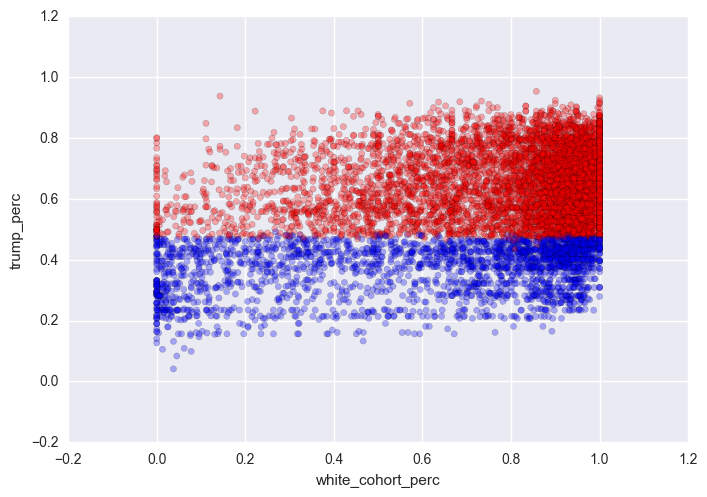

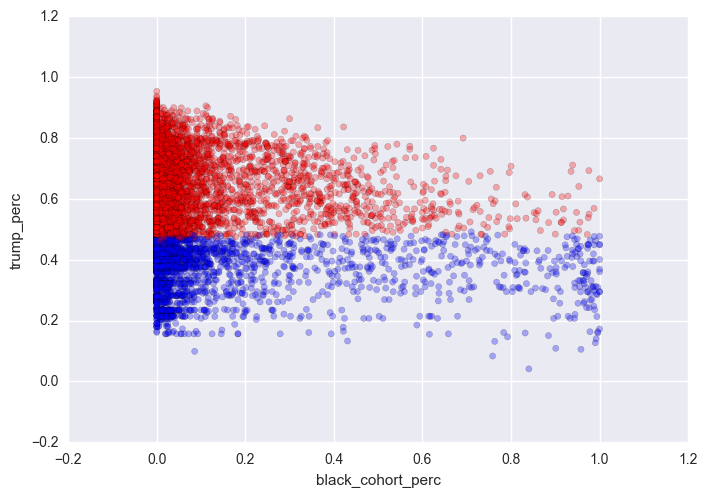

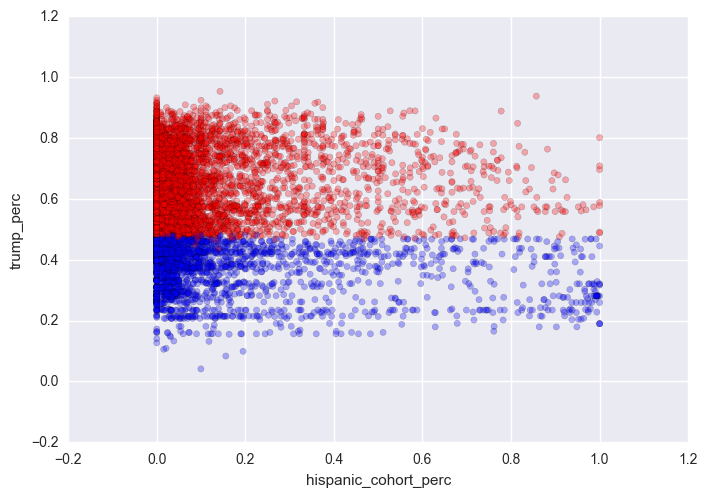

In [56]:
colors = np.where(df4.tag=='trump', 'r', 'b')
colors

#scatter plot - % of cohort for county vs % of votes of the county for trump
df4.plot(x='white_cohort_perc', y='trump_perc', kind='scatter', alpha=0.3, c = colors)

df4.plot(x='black_cohort_perc', y='trump_perc', kind='scatter', alpha=0.3,c = colors)

df4.plot(x='hispanic_cohort_perc', y='trump_perc', kind='scatter', alpha=0.3,c = colors)

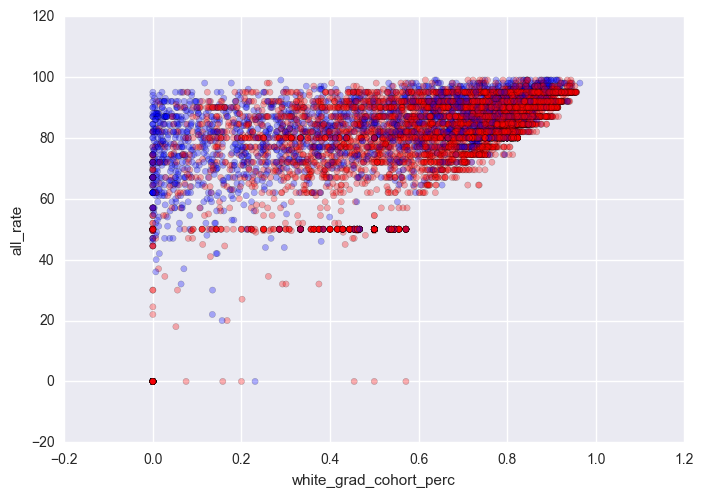

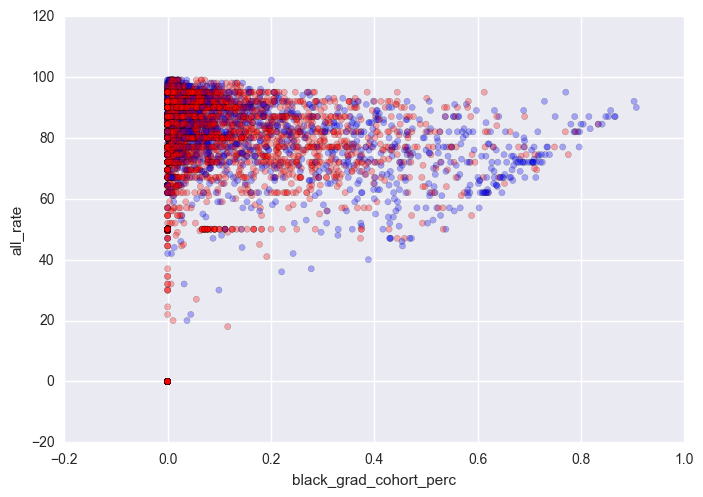

In [57]:
#scatter plot - % of cohort is white for county vs % of votes of the county for trump
df4.plot(x='white_grad_cohort_perc', y='all_rate', kind='scatter', alpha=0.3, c = colors)
#scatter plot - grad rate of white for county vs % of votes of the county for trump
df4.plot(x='black_grad_cohort_perc', y='all_rate', kind='scatter', alpha=0.3,c = colors)

In [58]:
drop_df = df4.drop(['trump_perc','clinton_perc','tag','tag_1','clinton','trump','tot_vote',u'state', u'school_district', u'CountyName', u'CountyFips', u'leaid11', u'st', u'StateName','region'],axis =1)

#drop_df = df4.drop(['trump_perc','clinton_perc','vc_pred','tag','tag_1','clinton','trump','tot_vote',u'state', u'school_district', u'CountyName', u'CountyFips', u'leaid11', u'st', u'StateName','region'],axis =1)

In [59]:
drop_df.columns

Index([u'all_cohort', u'all_rate', u'asian_cohort', u'black_cohort',
       u'hispanic_cohort', u'white_cohort', u'pct_urbanized_area_pop',
       u'pct_college_deg', u'pct_naturalized_pop', u'tot_pop', u'male_pop',
       u'female_pop', u'hispanic_pop', u'white_pop', u'black_pop',
       u'asian_pop', u'asian_rate', u'white_rate', u'black_rate',
       u'hispanic_rate', u'asian_grad_cohort', u'black_grad_cohort',
       u'hispanic_grad_cohort', u'white_grad_cohort', u'asian_cohort_perc',
       u'asian_pop_perc', u'asian_grad_rate', u'asian_grad_cohort_perc',
       u'black_cohort_perc', u'black_pop_perc', u'black_grad_rate',
       u'black_grad_cohort_perc', u'hispanic_cohort_perc',
       u'hispanic_pop_perc', u'hispanic_grad_rate',
       u'hispanic_grad_cohort_perc', u'white_cohort_perc', u'white_pop_perc',
       u'white_grad_rate', u'white_grad_cohort_perc', u'native_pop_perc',
       u'pub_assist_county', u'pub_assist_perc', u'pct_rural_area_pop',
       u'pct_cluster_area_pop'

In [132]:
df[['st','StateName','state']]

,st,StateName,state
0,AL,alabama,ALABAMA
1,AL,alabama,ALABAMA
2,AL,alabama,ALABAMA
3,AL,alabama,ALABAMA
4,AL,alabama,ALABAMA
5,AL,alabama,ALABAMA
6,AL,alabama,ALABAMA
7,AL,alabama,ALABAMA
8,AL,alabama,ALABAMA
9,AL,alabama,ALABAMA


In [60]:
df4.isnull().sum().sort_values(ascending = False)

region                         0
black_grad_rate                0
hispanic_rate                  0
asian_grad_cohort              0
black_grad_cohort              0
hispanic_grad_cohort           0
white_grad_cohort              0
asian_cohort_perc              0
asian_pop_perc                 0
asian_grad_rate                0
asian_grad_cohort_perc         0
black_cohort_perc              0
black_pop_perc                 0
black_grad_cohort_perc         0
pct_cluster_area_pop           0
hispanic_cohort_perc           0
hispanic_pop_perc              0
hispanic_grad_rate             0
hispanic_grad_cohort_perc      0
white_cohort_perc              0
white_pop_perc                 0
white_grad_rate                0
white_grad_cohort_perc         0
native_pop_perc                0
pub_assist_county              0
pub_assist_perc                0
black_rate                     0
white_rate                     0
asian_rate                     0
trump                          0
          

In [61]:
# define X and y
feature_cols = drop_df.columns
X = df4[feature_cols]
y = df4.tag_1
county_pred = df4[['CountyFips','st','tag_1','CountyName','trump_perc','all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','trump_perc','white_cohort_perc_county','asian_cohort_perc_county',
                   'black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','pct_urbanized_county','northeast','south','pacifica','midwest']].groupby(['CountyFips','st','CountyName']).mean().reset_index()

#X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc_county','white_cohort_perc_county','black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
y1 = county_pred.tag_1

In [62]:
# fit a classification tree with max_depth=6 on all data
RMSE_scores = []

from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth = 6, random_state=1)
treeclf.fit(X1, y1)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [63]:
MSE_scores =np.mean(cross_val_score(treeclf, X, y, cv=10, scoring='mean_squared_error'))
RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
np.mean(RMSE_scores)

0.39492976749817593

In [64]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
feature_cols = X1.columns
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values(by= 'importance', ascending = False)
#treereg.feature_importances_

,feature,importance
2,white_cohort_perc,0.431560
5,pct_college_deg_county,0.271108
1,asian_cohort_perc,0.136634
0,all_cohort_perc_county,0.050772
3,black_cohort_perc,0.035944
6,pct_rural_county,0.030418
9,south,0.022481
4,hispanic_cohort_perc,0.017140
8,northeast,0.003069
7,pct_cluster_county,0.000874


In [65]:


from sklearn.tree import DecisionTreeRegressor

# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treeclf, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

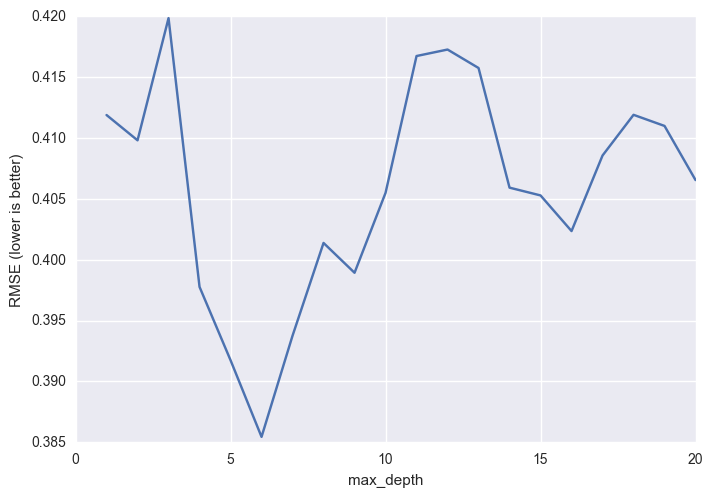

In [66]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [67]:
df4.columns

Index([u'state', u'school_district', u'CountyName', u'CountyFips',
       u'all_cohort', u'all_rate', u'asian_cohort', u'black_cohort',
       u'hispanic_cohort', u'white_cohort',
       ...
       u'black_ratio', u'hispanic_ratio', u'asian_ratio',
       u'all_cohort_perc_county', u'northeast', u'south', u'midwest',
       u'wildwest', u'pacifica', u'region'],
      dtype='object', length=109)

In [68]:
lm = smf.ols(formula='trump_perc ~ pct_college_deg + asian_pop_perc', data=df4).fit()
print lm.pvalues

Intercept           0.000000e+00
pct_college_deg    1.155099e-232
asian_pop_perc     5.248850e-110
dtype: float64


In [69]:
#fit logreg model to county data

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
#X = df4[['white_cohort_perc_county','asian_cohort_perc','asian_cohort_perc_county','white_cohort_perc','pct_college_deg_county','pct_urbanized_county','black_cohort_perc','black_cohort_perc_county','hispanic_cohort_perc','northeast','south','midwest','wildwest','pacifica']]
#X = df4[['black_cohort_perc','asian_cohort_perc','hispanic_cohort_perc','native_pop_county',
#         'pct_rural_county','pct_cluster_county']]
X = df4[['all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
#X = df4[['white_cohort_perc','white_cohort_perc_county','black_cohort_perc','black_cohort_perc_county','hispanic_cohort_perc','native_pop_perc','northeast','south','midwest','wildwest','pacifica']]
y = df4.tag_1
logreg = LogisticRegression()
cross_val_score(logreg, X1, y1, cv=10, scoring='accuracy').mean()

0.89762183964252829

In [70]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=1)

In [71]:
# create logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
# predict and calculate accuracy in one step
logreg.score(X_test, y_test)

0.90674318507890961

In [73]:
# predict in one step, calculate accuracy in a separate step
preds = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)

0.906743185079


In [74]:
# nicer confusion matrix
from nltk import ConfusionMatrix
print ConfusionMatrix(list(y_test), list(preds))

  |   0   1 |
--+---------+
0 | <67> 42 |
1 |  23<565>|
--+---------+
(row = reference; col = test)



(array([  20.,   15.,   15.,   21.,   19.,   16.,   25.,   24.,   81.,  461.]),
 array([ 0.00573312,  0.10512619,  0.20451925,  0.30391232,  0.40330539,
         0.50269846,  0.60209153,  0.70148459,  0.80087766,  0.90027073,
         0.9996638 ]),
 <a list of 10 Patch objects>)

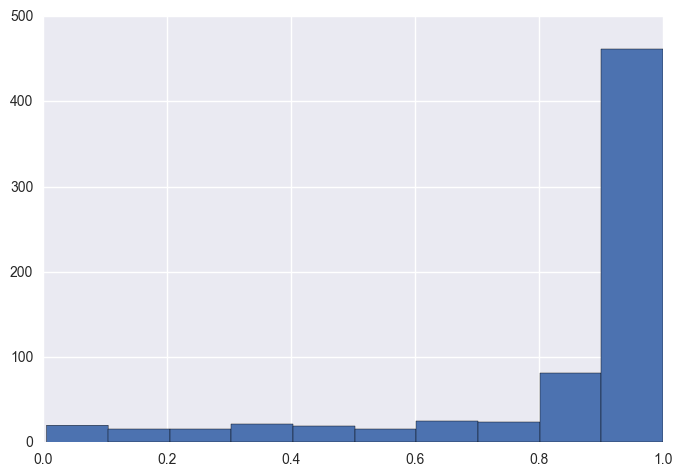

In [75]:
# predict probabilities
import matplotlib.pyplot as plt
probs = logreg.predict_proba(X_test)[:, 1]
plt.hist(probs)

In [76]:
# use 0.5 cutoff for predicting 'trump'
import numpy as np
preds = np.where(probs > 0.8, 1, 0)
print ConfusionMatrix(list(y_test), list(preds))

  |   0   1 |
--+---------+
0 | <86> 23 |
1 |  68<520>|
--+---------+
(row = reference; col = test)



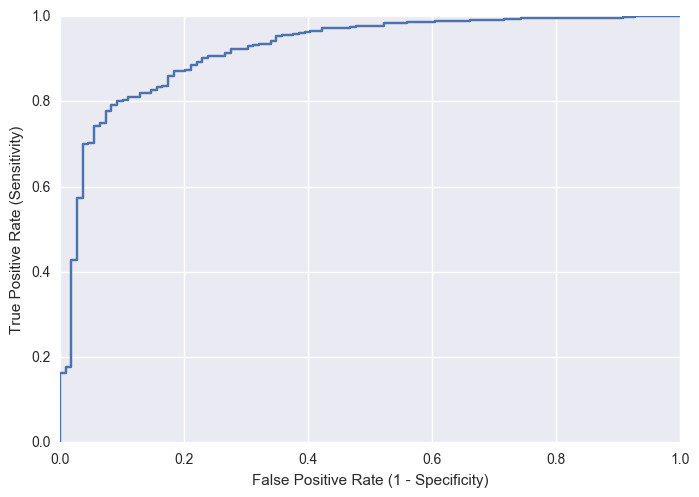

In [77]:
## ROC CURVES and AUC

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [78]:
## MODEL BUILDING WITH NAIVE BAYES
## http://scikit-learn.org/stable/modules/naive_bayes.html

# train a Naive Bayes model using X_train
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [79]:
preds = nb.predict(X_test)

In [80]:
# compare predictions to true labels
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)
print metrics.confusion_matrix(y_test, preds)

0.766140602582
[[ 75  34]
 [129 459]]


In [81]:
# predict (poorly calibrated) probabilities and calculate AUC
probs = nb.predict_proba(X_test)[:, 1]
probs
print metrics.roc_auc_score(y_test, probs)

0.757083567372


In [82]:
X_test

,all_cohort_perc_county,asian_cohort_perc,white_cohort_perc,black_cohort_perc,hispanic_cohort_perc,pct_college_deg_county,pct_rural_county,pct_cluster_county,northeast,south,pacifica,midwest
297,1.000000,0.025340,0.720334,0.148022,0.084981,7.068311,80.770000,0.000000,0,1,0,0
65,1.000000,0.000000,0.005882,0.994118,0.000000,7.110609,100.000000,0.000000,0,1,0,0
2497,1.000000,0.000000,0.391667,0.550000,0.000000,9.893993,100.000000,0.000000,1,0,0,0
28,1.000000,0.000000,0.857955,0.142045,0.000000,12.052796,68.820000,31.180000,0,1,0,0
2509,1.000000,0.010471,0.240838,0.727749,0.010471,11.119731,79.510000,20.490000,1,0,0,0
2100,1.000000,0.010327,0.939759,0.006885,0.034423,16.341030,11.930000,88.070000,0,1,0,0
2524,1.000000,0.006667,0.800000,0.106667,0.026667,20.729995,100.000000,0.000000,1,0,0,0
442,1.000000,0.010309,0.365979,0.603093,0.010309,9.352325,100.000000,0.000000,0,1,0,0
808,0.500000,0.000000,0.937304,0.000000,0.062696,20.764763,100.000000,0.000000,0,0,0,1
1432,0.500000,0.000000,1.000000,0.000000,0.000000,18.974700,100.000000,0.000000,0,0,0,0


In [83]:
# show the message text for the false positives
df6 = pd.DataFrame({'actual':y_test, 'prediction':preds})
df6

,actual,prediction
297,1,1
65,0,1
2497,1,1
28,1,1
2509,0,1
2100,1,0
2524,1,1
442,1,1
808,1,1
1432,1,1


In [84]:
new_preds = probs>=.8 #AUC says that if you change your threshhold, you can make naive bayes better
print metrics.accuracy_score(y_test, new_preds)

0.750358680057


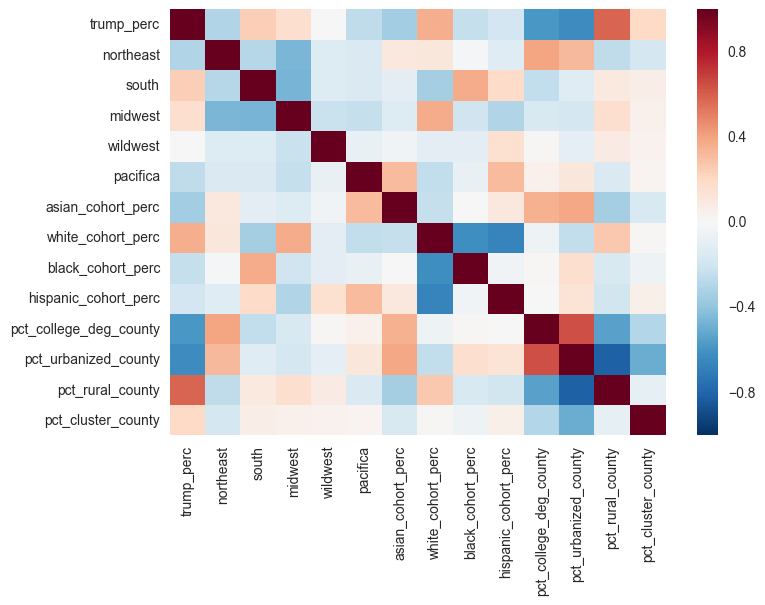

In [85]:
sns.heatmap(df4[['trump_perc','northeast','south','midwest','wildwest','pacifica','asian_cohort_perc',
                 'white_cohort_perc','black_cohort_perc','hispanic_cohort_perc',
                 'pct_college_deg_county','pct_urbanized_county','pct_rural_county','pct_cluster_county']].corr())

# Machine Learning Models

In [86]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [87]:
X = df4[['all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
y = df4.tag_1

In [88]:
#use scaled data if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
#models used in voting classifier
models = [('rf', RandomForestClassifier(n_estimators=150)),
          ('decision', DecisionTreeClassifier(max_depth=6)),
          ('LogReg', LogisticRegression()),
          #('NB', MultinomialNB()),
          #('KNN', KNeighborsClassifier(n_neighbors=23))
         ] 


In [90]:
# try a few models by themselves
for index, model in models:
    print index, np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    print

rf 0.846605463012

decision 0.830989780292

LogReg 0.850073548562



In [91]:
#run model at county level
county_pred = df4[['CountyFips','st','tag_1','CountyName','trump_perc','all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','trump_perc','white_cohort_perc_county','asian_cohort_perc_county',
                   'black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','pct_urbanized_county','northeast','south','pacifica','midwest']].groupby(['CountyFips','st','CountyName']).mean().reset_index()

#X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc_county','white_cohort_perc_county','black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
y1 = county_pred.tag_1
vc1 = VotingClassifier(models, voting='hard')
np.mean(cross_val_score(vc1, X1, y1, cv=10, scoring='accuracy'))



0.90804325446129641

In [92]:
#fit model on county data, predict on school district data
vc1.fit(X1,y1)
vc_pred_county = vc1.predict(X1)

print metrics.accuracy_score(y1, vc_pred_county)
print metrics.confusion_matrix(y1, vc_pred_county)

0.958348294434
[[ 355  102]
 [  14 2314]]


In [93]:
vc1 = VotingClassifier(models, voting='hard')
np.mean(cross_val_score(vc1, X, y, cv=10, scoring='accuracy'))

0.84729839230722792

In [94]:
#voting classifier prediction

#vc1.fit(X_scaled,y)
vc1.fit(X1,y1)
vc_pred = vc1.predict(X)

In [95]:
df4['vc_pred'] = vc_pred

In [96]:
print metrics.accuracy_score(y, vc_pred)
print metrics.confusion_matrix(y, vc_pred)

0.87987344356
[[1862  711]
 [ 466 6759]]


# Model Evaluation

In [97]:
#false negatives
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1)][['CountyFips','leaid11','state','CountyName','school_district','trump_perc',
                                            'tag_1','vc_pred','all_cohort','all_rate','white_cohort','asian_cohort_perc',
                 'white_cohort_perc', 'black_cohort_perc','hispanic_cohort_perc', 'pct_college_deg_county','native_pop_perc',
                 'pct_urbanized_county','pct_rural_county','pct_cluster_county']]

,CountyFips,leaid11,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_cohort,all_rate,white_cohort,asian_cohort_perc,white_cohort_perc,black_cohort_perc,hispanic_cohort_perc,pct_college_deg_county,native_pop_perc,pct_urbanized_county,pct_rural_county,pct_cluster_county
25,1015,100090,ALABAMA,Calhoun,Anniston City School District,0.692397,1,0,207,65.0,4.0,0.000000,0.019324,0.975845,0.004831,12.515366,0.003866,67.710000,21.884000,10.406000
39,1081,102580,ALABAMA,Lee,Opelika City School District,0.595148,1,0,320,81.0,106.0,0.015625,0.331250,0.606250,0.037500,27.746719,0.001203,72.706667,27.293333,0.000000
42,1005,100300,ALABAMA,Barbour,Barbour County School District,0.522714,1,0,81,62.0,6.0,0.000000,0.074074,0.913580,0.000000,15.843241,0.002442,0.000000,56.710000,43.290000
52,1017,101980,ALABAMA,Chambers,Lanett City School District,0.566338,1,0,49,74.5,3.0,0.000000,0.061224,0.918367,0.000000,11.270517,0.002366,0.000000,0.000000,100.000000
120,1109,103330,ALABAMA,Pike,Troy City School District,0.589712,1,0,198,57.0,61.0,0.000000,0.308081,0.661616,0.005051,22.297840,0.003601,0.000000,58.725000,41.275000
128,1125,103360,ALABAMA,Tuscaloosa,Tuscaloosa City School District,0.583798,1,0,787,71.0,153.0,0.019060,0.194409,0.759848,0.025413,27.765962,0.002400,79.270000,20.730000,0.000000
133,4013,400450,ARIZONA,Maricopa,Agua Fria Union High School District,0.492482,1,0,1614,82.0,645.0,0.053903,0.399628,0.117720,0.405204,27.688756,0.007694,90.235455,6.311818,3.452727
134,4013,401160,ARIZONA,Maricopa,Bicentennial Union High School District,0.492482,1,0,39,74.5,19.0,0.000000,0.487179,0.000000,0.461538,27.688756,0.008347,90.235455,6.311818,3.452727
135,4013,401410,ARIZONA,Maricopa,Buckeye Union High School District,0.492482,1,0,766,86.0,357.0,0.022193,0.466057,0.062663,0.430809,27.688756,0.009493,90.235455,6.311818,3.452727
136,4013,401740,ARIZONA,Maricopa,Casa Grande Union High School District,0.492482,1,0,775,76.0,240.0,0.021935,0.309677,0.050323,0.530323,27.688756,0.001479,90.235455,6.311818,3.452727


In [98]:
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1) & (df4.black_cohort_perc > .8) & (df4.all_cohort < df4.all_cohort_county)][['CountyFips','leaid11','state','CountyName','school_district','trump_perc',
                                                               'tag_1','vc_pred','all_cohort','all_cohort_county','white_cohort_perc','white_ratio','white_cohort_perc_county',
                                                                     'black_cohort_perc','black_cohort_perc_county','black_ratio','hispanic_cohort_perc',
                                                                     'hispanic_ratio','asian_cohort_perc','asian_ratio']].sort_values(by='black_ratio',ascending = False)

,CountyFips,leaid11,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_cohort,all_cohort_county,white_cohort_perc,white_ratio,white_cohort_perc_county,black_cohort_perc,black_cohort_perc_county,black_ratio,hispanic_cohort_perc,hispanic_ratio,asian_cohort_perc,asian_ratio
1751,17003,1708070,ILLINOIS,Alexander,Cairo Community Unit School District 1,0.530496,1,0,49,88,0.061224,0.111111,0.306818,0.918367,0.647727,0.789474,0.000000,0.000000,0.000000,0.000000
4149,28035,2801800,MISSISSIPPI,Forrest,Hattiesburg Public School District,0.555234,1,0,288,644,0.000000,0.000000,0.383540,0.947917,0.565217,0.750000,0.000000,0.000000,0.000000,0.000000
4129,28087,2801200,MISSISSIPPI,Lowndes,Columbus Municipal School District,0.522057,1,0,311,702,0.061093,0.077869,0.347578,0.913183,0.625356,0.646925,0.000000,0.000000,0.000000,0.000000
4084,28095,2800360,MISSISSIPPI,Monroe,Aberdeen School District,0.640454,1,0,128,438,0.000000,0.000000,0.538813,0.953125,0.433790,0.642105,0.000000,0.000000,0.000000,0.000000
4179,28075,2802910,MISSISSIPPI,Lauderdale,Meridian Public School District,0.606690,1,0,271,753,0.066421,0.052786,0.452855,0.915129,0.528552,0.623116,0.000000,0.000000,0.000000,0.000000
4125,28161,2801140,MISSISSIPPI,Yalobusha,Coffeeville School District,0.555629,1,0,51,126,0.000000,0.000000,0.309524,0.901961,0.603175,0.605263,0.000000,0.000000,0.000000,0.000000
4197,28101,2803180,MISSISSIPPI,Newton,Newton Municipal School,0.689900,1,0,62,257,0.000000,0.000000,0.533074,0.935484,0.392996,0.574257,0.000000,0.000000,0.000000,0.000000
279,5093,503320,ARKANSAS,Mississippi,Blytheville School District,0.534455,1,0,215,592,0.167442,0.137931,0.440878,0.813953,0.516892,0.571895,0.018605,0.190476,0.000000,0.000000
4172,28067,2802460,MISSISSIPPI,Jones,Laurel School District,0.710655,1,0,197,750,0.000000,0.000000,0.517333,0.939086,0.440000,0.560606,0.000000,0.000000,0.000000,0.000000
2859,22073,2201080,LOUISIANA,Ouachita,Monroe City School District,0.613529,1,0,588,1901,0.147959,0.092850,0.492898,0.831633,0.487638,0.527508,0.006803,0.173913,0.011905,0.538462


Examples of segregated school districts in CountyFips: 
 * Bolivar County, Mississippi: 28011
 * Mississippi County, Missouri: 29133
 * Oneida County, New York: 36065
 * Erie County, Pennsylvania: 42049

In [99]:
df4[(df4.CountyFips == 28095)][['CountyFips','state','CountyName','school_district','trump_perc',
                               'tag_1','vc_pred','all_rate']]

,CountyFips,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_rate
4084,28095,MISSISSIPPI,Monroe,Aberdeen School District,0.640454,1,0,67.0
4085,28095,MISSISSIPPI,Monroe,Amory School District,0.640454,1,1,72.0
4086,28095,MISSISSIPPI,Monroe,Monroe County School District,0.640454,1,1,82.0


In [100]:
df4[(df4.CountyFips == 28095)][['CountyFips','state','CountyName','school_district','trump_perc',
                               'tag_1','vc_pred','all_cohort','all_cohort_county','white_cohort_perc',
                               'white_ratio','black_cohort_perc','black_cohort_perc_county',
                               'black_ratio','hispanic_cohort_perc','hispanic_ratio',
                               'pct_college_deg','pct_urbanized_county','pct_cluster_county','pct_rural_county']]

,CountyFips,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_cohort,all_cohort_county,white_cohort_perc,white_ratio,black_cohort_perc,black_cohort_perc_county,black_ratio,hispanic_cohort_perc,hispanic_ratio,pct_college_deg,pct_urbanized_county,pct_cluster_county,pct_rural_county
4084,28095,MISSISSIPPI,Monroe,Aberdeen School District,0.640454,1,0,128,438,0.000000,0.000000,0.953125,0.43379,0.642105,0.0,0.0,19.885057,0.0,56.23,43.77
4085,28095,MISSISSIPPI,Monroe,Amory School District,0.640454,1,1,128,438,0.585938,0.317797,0.390625,0.43379,0.263158,0.0,0.0,6.686542,0.0,56.23,43.77
4086,28095,MISSISSIPPI,Monroe,Monroe County School District,0.640454,1,1,182,438,0.884615,0.682203,0.098901,0.43379,0.094737,0.0,0.0,11.531712,0.0,56.23,43.77


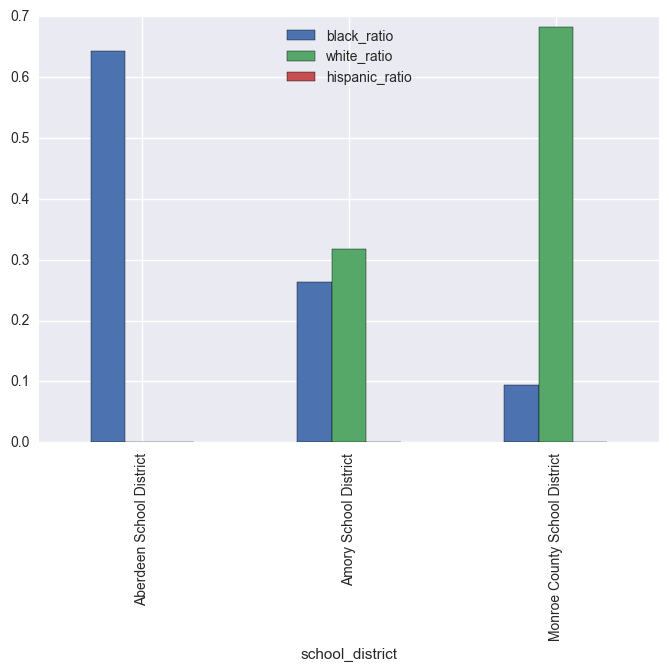

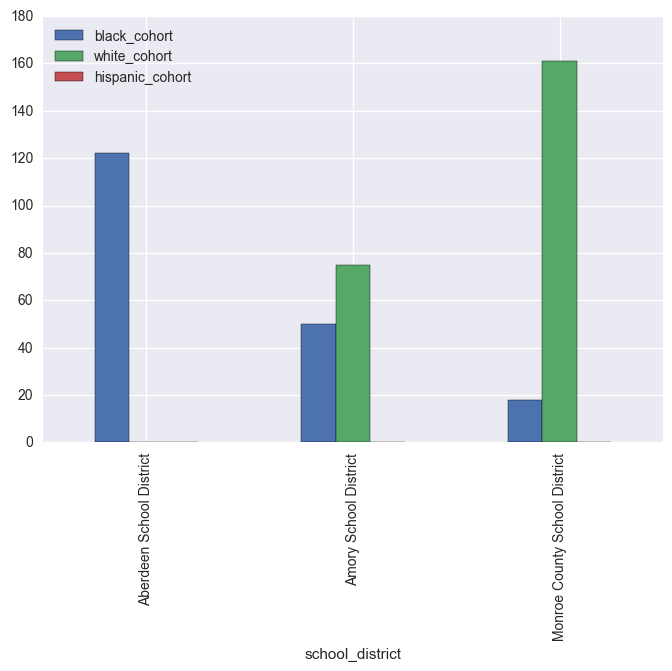

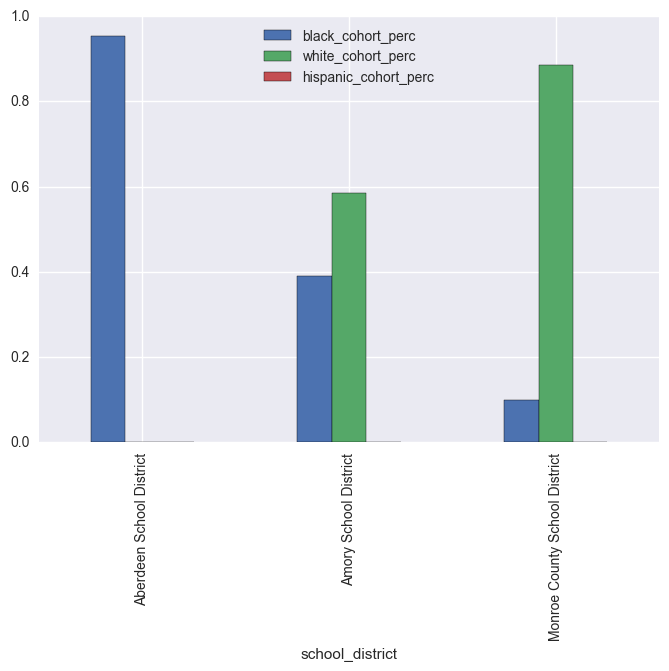

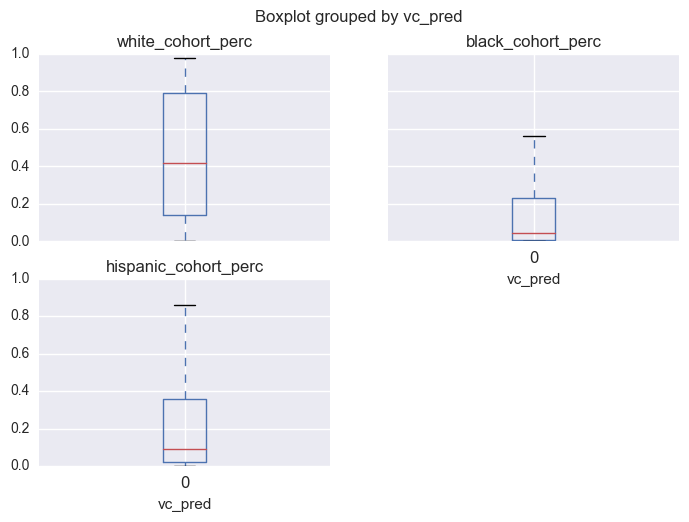

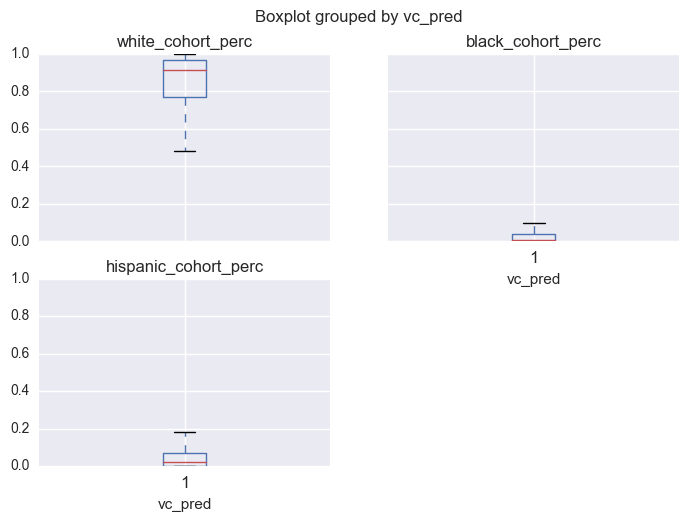

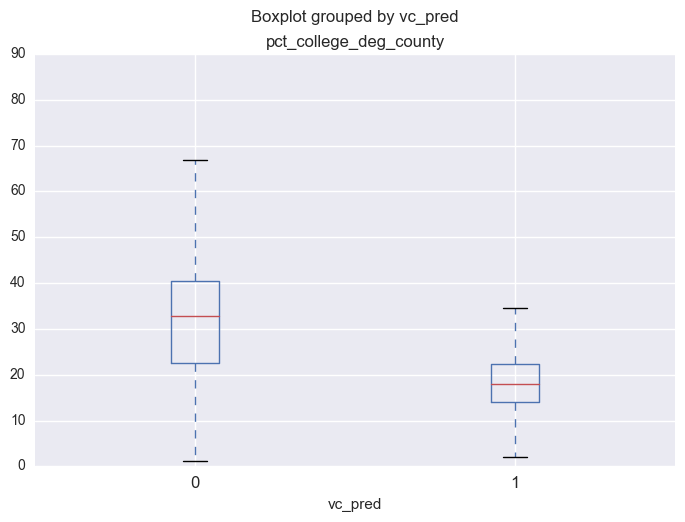

In [101]:
Fips = 28095

# & (df4.tag_1 != df4.vc_pred)

df4[(df4.CountyFips == Fips)][['school_district','black_ratio','white_ratio','hispanic_ratio']].plot(kind = 'bar', x = 'school_district')
df4[(df4.CountyFips == Fips)][['school_district','black_cohort','white_cohort','hispanic_cohort']].plot(kind = 'bar', x = 'school_district')
df4[(df4.CountyFips == Fips)][['school_district','black_cohort_perc','white_cohort_perc','hispanic_cohort_perc']].plot(kind = 'bar', x = 'school_district')
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1)].boxplot(column=['white_cohort_perc','black_cohort_perc','hispanic_cohort_perc'], by='vc_pred')
df4[df4.vc_pred == 1].boxplot(column=['white_cohort_perc','black_cohort_perc','hispanic_cohort_perc'], by='vc_pred')
df4.boxplot(column=['pct_college_deg_county'], by='vc_pred')

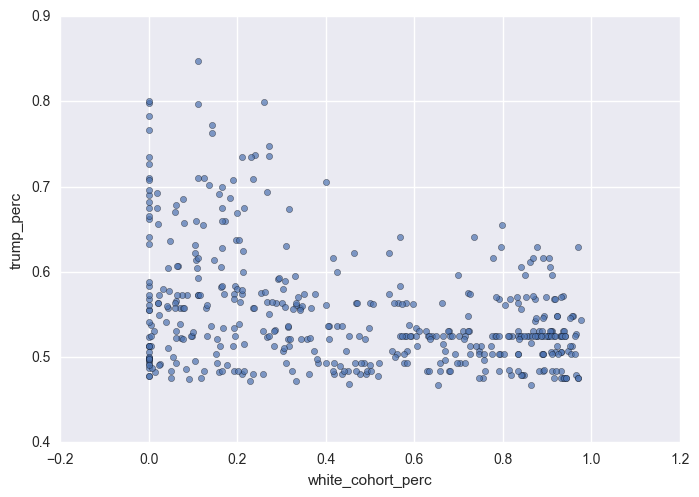

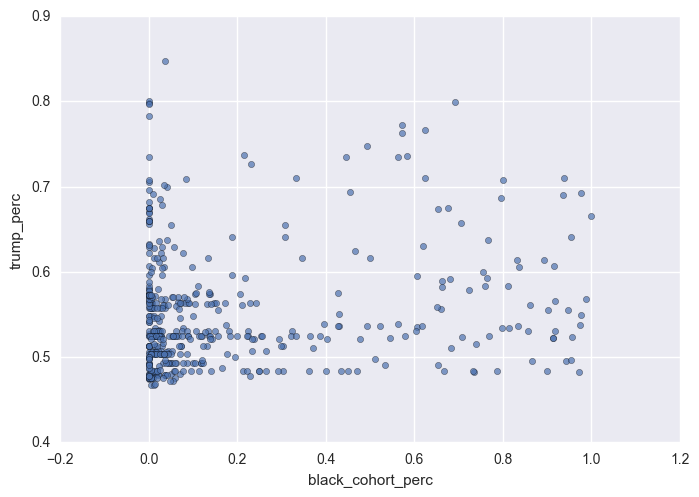

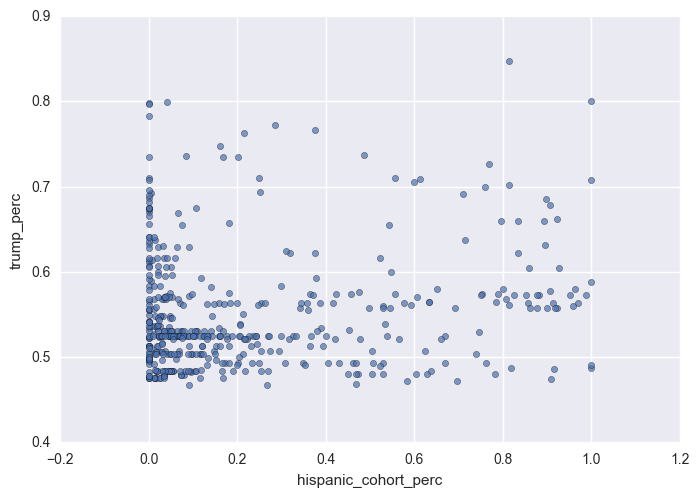

In [102]:
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1) & (df4.all_cohort < df4.all_cohort_county )].plot(x='white_cohort_perc', y='trump_perc', kind='scatter', alpha=.7)

df4[(df4.vc_pred == 0) & (df4.tag_1 == 1) & (df4.all_cohort < df4.all_cohort_county )].plot(x='black_cohort_perc', y='trump_perc', kind='scatter', alpha=.7)

df4[(df4.vc_pred == 0) & (df4.tag_1 == 1) & (df4.all_cohort < df4.all_cohort_county )].plot(x='hispanic_cohort_perc', y='trump_perc', kind='scatter', alpha=.7)

# Predictions by region

In [103]:
df4[df4.vc_pred == 1][['st','region','northeast','south','midwest','wildwest','pacifica']].groupby('region').sum()

,northeast,south,midwest,wildwest,pacifica
region,,,,,
midwest,0,0,3718,0,0
northeast,1163,0,0,0,0
pacifica,0,0,0,0,308
south,0,1812,0,0,0
wildwest,0,0,0,469,0


In [104]:
df4[df4.tag_1 == 1][['st','region','northeast','south','midwest','wildwest','pacifica']].groupby('region').sum()

,northeast,south,midwest,wildwest,pacifica
region,,,,,
midwest,0,0,3537,0,0
northeast,1100,0,0,0,0
pacifica,0,0,0,0,259
south,0,1845,0,0,0
wildwest,0,0,0,484,0


In [105]:
df4[df4.tag_1 != df4.vc_pred][['st','region','northeast','south','midwest','wildwest','pacifica']].groupby('region').sum()

,northeast,south,midwest,wildwest,pacifica
region,,,,,
midwest,0,0,353,0,0
northeast,399,0,0,0,0
pacifica,0,0,0,0,155
south,0,155,0,0,0
wildwest,0,0,0,115,0


In [106]:
df4[df4.tag_1 == df4.vc_pred][['st','region','northeast','south','midwest','wildwest','pacifica']].groupby('region').sum()

,northeast,south,midwest,wildwest,pacifica
region,,,,,
midwest,0,0,3835,0,0
northeast,1735,0,0,0,0
pacifica,0,0,0,0,518
south,0,2032,0,0,0
wildwest,0,0,0,501,0


In [107]:
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1) & (df4.trump_perc > .6)][['CountyFips','leaid11','state','CountyName','school_district','trump_perc',
                                                                    'tag_1','vc_pred','all_rate','all_rate_county','all_cohort','all_cohort_county','white_cohort_perc','white_ratio',
                                                                    'black_cohort_perc','black_cohort_perc_county','black_ratio','hispanic_cohort_perc',
                                                                    'hispanic_ratio','pct_urbanized_county','pct_college_deg_county']]

,CountyFips,leaid11,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_rate,all_rate_county,...,all_cohort_county,white_cohort_perc,white_ratio,black_cohort_perc,black_cohort_perc_county,black_ratio,hispanic_cohort_perc,hispanic_ratio,pct_urbanized_county,pct_college_deg_county
25,1015,100090,ALABAMA,Calhoun,Anniston City School District,0.692397,1,0,65.0,83.000000,...,1418,0.019324,0.004242,0.975845,0.306770,0.464368,0.004831,0.035714,67.710000,12.515366
228,4009,403200,ARIZONA,Graham,Fort Thomas Unified District,0.670771,1,0,54.5,76.625000,...,420,0.058824,0.009950,0.000000,0.019048,0.000000,0.000000,0.000000,0.000000,15.946117
236,4007,406960,ARIZONA,Gila,San Carlos Unified District,0.632566,1,0,52.0,73.500000,...,462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.309951
296,5027,512870,ARKANSAS,Columbia,Stephens School District,0.613930,1,0,69.5,78.333333,...,299,0.107143,0.020979,0.892857,0.501672,0.166667,0.000000,0.000000,0.000000,21.175489
422,5061,509780,ARKANSAS,Howard,Mineral Springs School District,0.675444,1,0,90.0,87.333333,...,206,0.216216,0.062992,0.675676,0.218447,0.555556,0.108108,0.125000,0.000000,11.293114
991,8083,803390,COLORADO,Montezuma,Dolores School District RE-4A,0.611601,1,0,84.5,72.166667,...,279,0.860465,0.211429,0.023256,0.010753,0.333333,0.000000,0.000000,0.000000,32.025968
1317,13313,1301620,GEORGIA,Whitfield,Dalton City School District,0.708583,1,0,76.0,70.000000,...,1352,0.235955,0.116505,0.084270,0.042160,0.526316,0.612360,0.425781,79.070000,33.709148
1327,13175,1301870,GEORGIA,Laurens,Dublin City School District,0.637649,1,0,72.0,71.000000,...,700,0.196891,0.104396,0.766839,0.434286,0.486842,0.015544,0.150000,0.000000,19.837863
1341,13139,1302310,GEORGIA,Hall,Gainesville City School District,0.736900,1,0,67.0,70.500000,...,2199,0.240291,0.086012,0.216019,0.089586,0.451777,0.485437,0.268097,91.260000,32.681404
2784,20175,2008730,KANSAS,Seward,Liberal Unified School District 480,0.637782,1,0,88.0,89.000000,...,349,0.205212,0.759036,0.042345,0.037249,1.000000,0.713355,0.916318,0.000000,18.237154


In [108]:
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1)].groupby('st').count()
#df4.groupby(['st']).count()

,state,school_district,CountyName,CountyFips,all_cohort,all_rate,asian_cohort,black_cohort,hispanic_cohort,white_cohort,...,hispanic_ratio,asian_ratio,all_cohort_perc_county,northeast,south,midwest,wildwest,pacifica,region,vc_pred
st,,,,,,,,,,,,,,,,,,,,,
AL,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
AR,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
AZ,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
CA,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
CO,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
CT,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
DE,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GA,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
IA,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [109]:
df4[(df4.CountyName == 'Suffolk')][['CountyFips','leaid11','state','CountyName','school_district','trump_perc',
                                                                    'tag_1','vc_pred','all_rate','all_rate_county','all_cohort','all_cohort_county','white_cohort_perc','white_ratio',
                                                                    'black_cohort_perc','black_cohort_perc_county','black_ratio','hispanic_cohort_perc',
                                                                    'hispanic_ratio','pct_urbanized_county','pct_college_deg_county']]

,CountyFips,leaid11,state,CountyName,school_district,trump_perc,tag_1,vc_pred,all_rate,all_rate_county,...,all_cohort_county,white_cohort_perc,white_ratio,black_cohort_perc,black_cohort_perc_county,black_ratio,hispanic_cohort_perc,hispanic_ratio,pct_urbanized_county,pct_college_deg_county
5610,36103,3600008,NEW YORK,Suffolk,South Country Central School District,0.52484,1,0,78.0,87.127273,...,20569,0.475460,0.010859,0.322086,0.105839,0.048232,0.177914,0.017512,86.962727,37.088757
5611,36103,3600021,NEW YORK,Suffolk,Mattituck-Cutchogue Union Free School District,0.52484,1,0,95.0,87.127273,...,20569,0.876712,0.008967,0.020548,0.105839,0.001378,0.082192,0.003623,86.962727,37.088757
5612,36103,3600125,NEW YORK,Suffolk,Eastport-South Manor Central School District,0.52484,1,0,96.0,87.127273,...,20569,0.915152,0.021157,0.015152,0.105839,0.002297,0.048485,0.004831,86.962727,37.088757
5613,36103,3602940,NEW YORK,Suffolk,Amityville Union Free School District,0.52484,1,0,73.0,87.127273,...,20569,0.132530,0.002312,0.578313,0.105839,0.066146,0.269076,0.020229,86.962727,37.088757
5614,36103,3603720,NEW YORK,Suffolk,Babylon Union Free School District,0.52484,1,0,92.0,87.127273,...,20569,0.782313,0.008057,0.088435,0.105839,0.005972,0.088435,0.003925,86.962727,37.088757
5615,36103,3604080,NEW YORK,Suffolk,Bay Shore Union Free School District,0.52484,1,0,85.0,87.127273,...,20569,0.451820,0.014782,0.224839,0.105839,0.048232,0.299786,0.042271,86.962727,37.088757
5616,36103,3604110,NEW YORK,Suffolk,Bayport-Blue Point Union Free School District,0.52484,1,0,95.0,87.127273,...,20569,0.941176,0.013451,0.019608,0.105839,0.001837,0.029412,0.001812,86.962727,37.088757
5617,36103,3605280,NEW YORK,Suffolk,Brentwood Union Free School District,0.52484,1,0,72.0,87.127273,...,20569,0.098669,0.008827,0.199687,0.105839,0.117134,0.668755,0.257850,86.962727,37.088757
5618,36103,3605370,NEW YORK,Suffolk,Bridgehampton Union Free School District,0.52484,1,0,50.0,87.127273,...,20569,0.272727,0.000210,0.363636,0.105839,0.001837,0.272727,0.000906,86.962727,37.088757
5619,36103,3606840,NEW YORK,Suffolk,Center Moriches Union Free School District,0.52484,1,0,92.0,87.127273,...,20569,0.821192,0.008687,0.052980,0.105839,0.003675,0.046358,0.002114,86.962727,37.088757


In [110]:
df4[(df4.st == 'NY') & (df4.vc_pred == 0) & (df4.tag_1 == 1)][['CountyFips','state','CountyName','school_district','trump_perc',
                                                               'tag_1','vc_pred','white_ratio','black_ratio','all_cohort','all_rate','asian_cohort_perc',
                 'white_cohort_perc', 'black_cohort_perc','hispanic_cohort_perc', 'pct_college_deg_county','native_pop_county',
                 'pct_urbanized_county','pct_rural_county','pct_cluster_county']]

,CountyFips,state,CountyName,school_district,trump_perc,tag_1,vc_pred,white_ratio,black_ratio,all_cohort,all_rate,asian_cohort_perc,white_cohort_perc,black_cohort_perc,hispanic_cohort_perc,pct_college_deg_county,native_pop_county,pct_urbanized_county,pct_rural_county,pct_cluster_county
5610,36103,NEW YORK,Suffolk,South Country Central School District,0.524840,1,0,0.010859,0.048232,326,78.0,0.015337,0.475460,0.322086,0.177914,37.088757,463,86.962727,7.104364,5.932909
5611,36103,NEW YORK,Suffolk,Mattituck-Cutchogue Union Free School District,0.524840,1,0,0.008967,0.001378,146,95.0,0.020548,0.876712,0.020548,0.082192,37.088757,463,86.962727,7.104364,5.932909
5612,36103,NEW YORK,Suffolk,Eastport-South Manor Central School District,0.524840,1,0,0.021157,0.002297,330,96.0,0.018182,0.915152,0.015152,0.048485,37.088757,463,86.962727,7.104364,5.932909
5613,36103,NEW YORK,Suffolk,Amityville Union Free School District,0.524840,1,0,0.002312,0.066146,249,73.0,0.016064,0.132530,0.578313,0.269076,37.088757,463,86.962727,7.104364,5.932909
5614,36103,NEW YORK,Suffolk,Babylon Union Free School District,0.524840,1,0,0.008057,0.005972,147,92.0,0.040816,0.782313,0.088435,0.088435,37.088757,463,86.962727,7.104364,5.932909
5615,36103,NEW YORK,Suffolk,Bay Shore Union Free School District,0.524840,1,0,0.014782,0.048232,467,85.0,0.021413,0.451820,0.224839,0.299786,37.088757,463,86.962727,7.104364,5.932909
5616,36103,NEW YORK,Suffolk,Bayport-Blue Point Union Free School District,0.524840,1,0,0.013451,0.001837,204,95.0,0.009804,0.941176,0.019608,0.029412,37.088757,463,86.962727,7.104364,5.932909
5617,36103,NEW YORK,Suffolk,Brentwood Union Free School District,0.524840,1,0,0.008827,0.117134,1277,72.0,0.031323,0.098669,0.199687,0.668755,37.088757,463,86.962727,7.104364,5.932909
5618,36103,NEW YORK,Suffolk,Bridgehampton Union Free School District,0.524840,1,0,0.000210,0.001837,11,50.0,0.090909,0.272727,0.363636,0.272727,37.088757,463,86.962727,7.104364,5.932909
5619,36103,NEW YORK,Suffolk,Center Moriches Union Free School District,0.524840,1,0,0.008687,0.003675,151,92.0,0.013245,0.821192,0.052980,0.046358,37.088757,463,86.962727,7.104364,5.932909


# Predicting at the county level using the predictions from school districts

In [111]:
#create weighted predictions per school district to be rolled up into by county
county_pred_weight = []
for index, row in df4.iterrows():
    county_pred_weight.append(row['vc_pred']*row['all_cohort_perc_county'])

In [112]:
df4['county_pred_weight'] = county_pred_weight

In [113]:
preds = df4[['CountyFips','st','county_pred_weight']].groupby(['CountyFips','st']).sum().reset_index()
preds['county_vc_pred'] = preds['county_pred_weight'].apply(lambda x:int(round(x)))
preds

,CountyFips,st,county_pred_weight,county_vc_pred
0,1001,AL,1.000000,1
1,1003,AL,1.000000,1
2,1005,AL,0.757485,1
3,1007,AL,1.000000,1
4,1009,AL,1.000000,1
5,1011,AL,0.000000,0
6,1013,AL,1.000000,1
7,1015,AL,0.854020,1
8,1017,AL,0.860795,1
9,1019,AL,1.000000,1


In [114]:
county_pred = df4[['CountyFips','st','tag_1','CountyName','trump_perc','all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','trump_perc','white_cohort_perc_county','asian_cohort_perc_county',
                   'black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','pct_urbanized_county','northeast','south','pacifica','midwest']].groupby(['CountyFips','st','CountyName']).mean().reset_index()

In [115]:
#county_pred['county_vc_pred'] = county_pred['vc_pred'].apply(lambda x:int(round(x)))
#county_pred
county_pred['county_vc_pred'] = preds['county_vc_pred']

In [116]:
#accuracy at county level
print metrics.accuracy_score(county_pred['county_vc_pred'], county_pred['tag_1'])
print metrics.confusion_matrix(county_pred['county_vc_pred'], county_pred['tag_1'])

0.941472172352
[[ 343   49]
 [ 114 2279]]


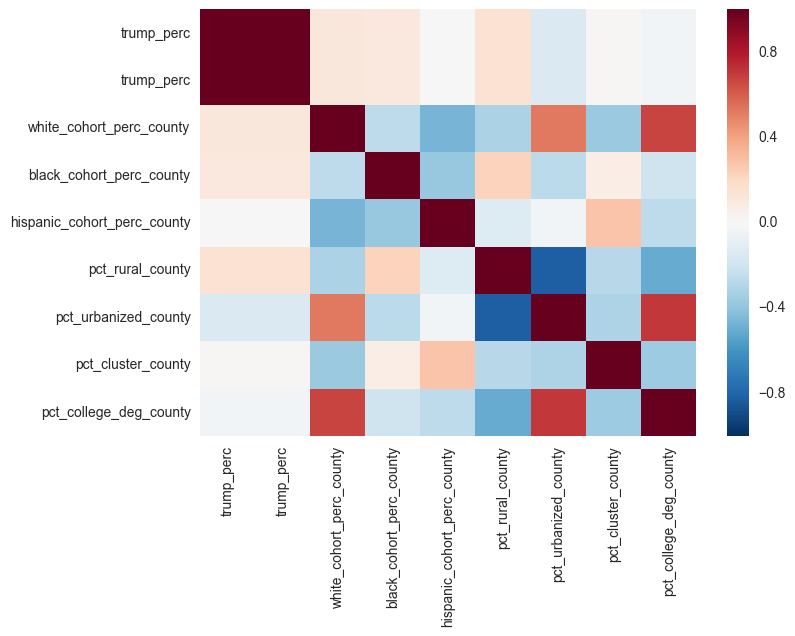

In [117]:
sns.heatmap(county_pred[(county_pred.tag_1 == 1) & (county_pred.county_vc_pred == 0)][['trump_perc','white_cohort_perc_county',
                                                                                       'black_cohort_perc_county','hispanic_cohort_perc_county',
                                                                                       'pct_rural_county','pct_urbanized_county','pct_cluster_county',
                                                                                       'pct_college_deg_county']].corr())


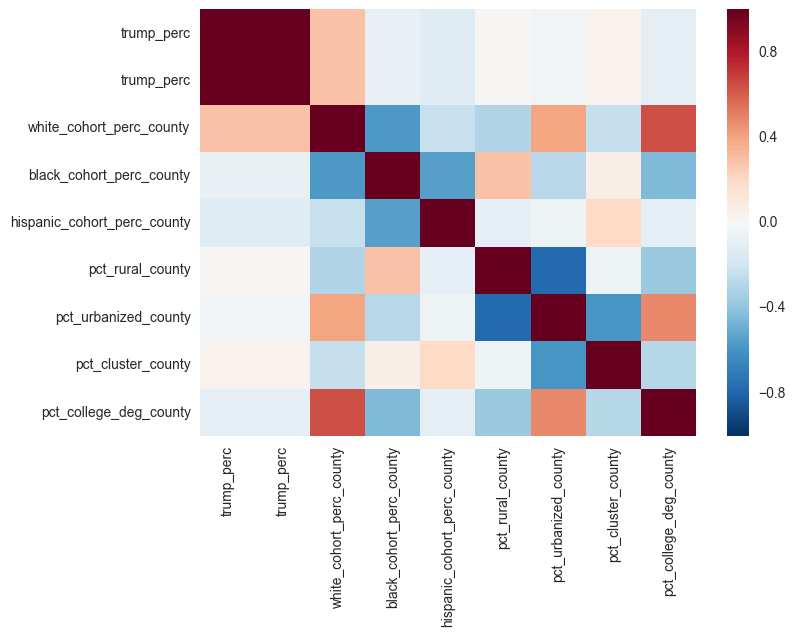

In [118]:
sns.heatmap(county_pred[(county_pred.tag_1 == 0) & (county_pred.county_vc_pred == 0)][['trump_perc','white_cohort_perc_county',
                                                                                       'black_cohort_perc_county','hispanic_cohort_perc_county',
                                                                                       'pct_rural_county','pct_urbanized_county','pct_cluster_county',
                                                                                       'pct_college_deg_county']].corr())

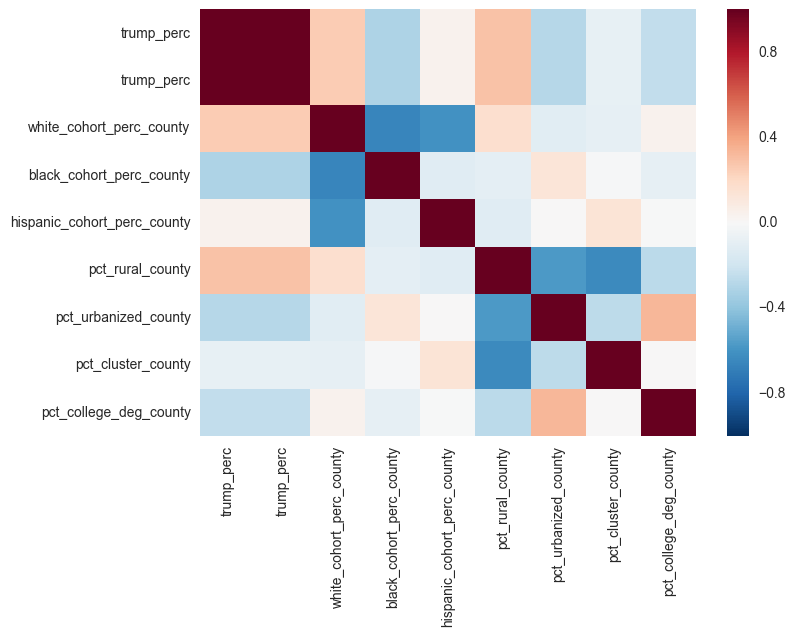

In [119]:
sns.heatmap(county_pred[(county_pred.tag_1 == 1) & (county_pred.county_vc_pred == 1)][['trump_perc','white_cohort_perc_county',
                                                                                       'black_cohort_perc_county','hispanic_cohort_perc_county',
                                                                                       'pct_rural_county','pct_urbanized_county','pct_cluster_county',
                                                                                       'pct_college_deg_county']].corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AEF8278>]], dtype=object)

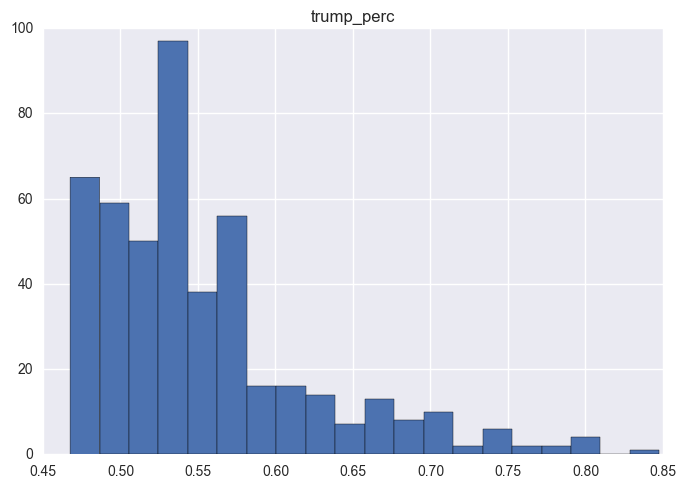

In [120]:
df4[(df4.vc_pred == 0) & (df4.tag_1 == 1)].hist('trump_perc',bins=20)

# Voting Classifier at county level

In [121]:
#X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc_county','white_cohort_perc_county','black_cohort_perc_county','hispanic_cohort_perc_county','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
X1 = county_pred[['all_cohort_perc_county','asian_cohort_perc','white_cohort_perc','black_cohort_perc','hispanic_cohort_perc','pct_college_deg_county','pct_rural_county','pct_cluster_county','northeast','south','pacifica','midwest']]
y1 = county_pred.tag_1

In [122]:
vc1 = VotingClassifier(models, voting='hard')
np.mean(cross_val_score(vc1, X1, y1, cv=10, scoring='accuracy'))

0.90805231673517606

In [123]:

vc1.fit(X1,y1)
vc_pred_county = vc1.predict(X1)

print metrics.accuracy_score(y1, vc_pred_county)
print metrics.confusion_matrix(y1, vc_pred_county)

0.958707360862
[[ 356  101]
 [  14 2314]]
